In [6]:
%load_ext autoreload  
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pandas as pd
import geopandas as gpd
import swifter

pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import stc_unicef_cpi.data.process_geotiff as pg
import h3.api.numpy_int as h3

from pathlib import Path


In [8]:
from stc_unicef_cpi.data.cv_loaders import cv_split  

In [9]:
base_dir = Path("/Users/johnf/Downloads/higher_res_dssg/")
tiff_dir = base_dir / "500m_res"
econ_dir = base_dir / "econ"
connectivity_dir = base_dir / "connectivity"
clean_base = base_dir / "nga_clean_v2.csv"
rwi_path = base_dir / "NGA_relative_wealth_index.csv"
comm_zns = base_dir / "commuting-zones-bdrys.csv"
fb_conn = connectivity_dir / "fb_nigeria.csv"


In [ ]:
# NB nga has lats between 4.2 and 13.9, longs between 2.6 and 14.7


# Spatial CV tests

In [ ]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
nga = world[world.name == "Nigeria"].geometry.__geo_interface__['features'][0]['geometry']
nga_hex = h3.polyfill(nga,res=7)

In [ ]:
base_dir = Path("/Users/johnf/Downloads/higher_res_dssg/")
all_data = base_dir / "clean_nga_w_autov1.csv"
thr_data = base_dir / "nga_clean_v2_thr30.csv"
all_df = pd.read_csv(all_data)
all_df['name_commuting_zone'] = all_df['name_commuting_zone'].astype('category')
thr_df = pd.read_csv(thr_data)
thr_all = all_df.set_index('hex_code').loc[thr_df.hex_code].reset_index()

In [ ]:
import seaborn as sns 
k = 10
N = 1000
samp_hex = np.random.choice(thr_all['hex_code'], size=N, replace=False)
labels = np.random.rand(N)
folds = cv_split(samp_hex,labels=labels,k=k,mode='spatial')
# sns.distplot(folds,kde=False, bins=k)
fig,ax = plt.subplots(dpi=150) 
latlongs = np.array([h3.h3_to_geo(hex) for hex in samp_hex]) 
for _, test_idxs in folds: 
    ax.scatter(latlongs[test_idxs,1],latlongs[test_idxs,0])
plt.show()

In [ ]:
from stc_unicef_cpi.data.cv_loaders import HexSpatialKFold 
latlongs = np.array([h3.h3_to_geo(hex) for hex in samp_hex]) 
for train_idx, test_idx in HexSpatialKFold().split(samp_hex,labels): 
    fig,ax = plt.subplots(dpi=150) 
    ax.scatter(latlongs[train_idx,1],latlongs[train_idx,0],c='g')
    ax.scatter(latlongs[test_idx,1],latlongs[test_idx,0],c='r')
    plt.show()

# Connectivity data

In [ ]:
# import dask.dataframe as dd
# from dask.delayed import delayed
# parts = delayed(pd.read_excel)(connectivity_dir / 'cell_tower_nga.xlsx',
#                                     sheet_name=0)
# df = dd.from_delayed(parts)
nga_cell_df = pd.read_excel(connectivity_dir / "cell_tower_nga.xlsx", sheet_name=0)


In [ ]:
nga_cell_df.head()
# will just want radio (generation category - want counts / cell if possible)
# and possibly avg_signal, though generally 0
# Most likely just overall count will be most useful


In [ ]:
nga_cell_df["hex_code"] = nga_cell_df[["lat", "long"]].swifter.apply(
    lambda x: h3.geo_to_h3(x[0], x[1], resolution=7), axis=1
)


In [ ]:
nga_cell_df = nga_cell_df[["hex_code", "radio", "avg_signal"]]


In [ ]:
nga_cell_df.groupby(["hex_code", "radio"]).size().unstack(level=1).fillna(0).join(
    nga_cell_df.groupby("hex_code").avg_signal.mean()
).to_csv(connectivity_dir / "nga_cell_clean.csv")


In [ ]:
import shapely.wkt

# speed_df = dd.read_csv(connectivity_dir/"speedtest_world.csv",blocksize=25e6).set_index("Unnamed: 0")  # 25MB chunks
speed_df = pd.read_csv(connectivity_dir / "speedtest_world.csv", index_col=0)
speed_df["geometry"] = speed_df.geometry.swifter.apply(shapely.wkt.loads)


In [ ]:
speed_df = gpd.GeoDataFrame(speed_df, crs="epsg:4326")


In [ ]:
speed_df.head().plot()

In [ ]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
nga_speed_df = gpd.sjoin(
    speed_df, world[world.name == "Nigeria"], how="inner", op="intersects"
)


In [ ]:
# def centroid_lat_from_shply(wkt_str):
#     try:
#         return shapely.wkt.loads(wkt_str).centroid.coords.xy[1]
#     except:
#         # assume wkt reading error
#         return np.nan
# def centroid_long_from_shply(wkt_str):
#     try:
#         return shapely.wkt.loads(wkt_str).centroid.coords.xy[0]
#     except:
#         # assume wkt reading error
#         return np.nan

# def centroid_latlong_from_shply(wkt_str):
#     try:
#         return np.array(shapely.wkt.loads(wkt_str).centroid.coords.xy).flatten()
#     except:
#         # assume wkt reading error
#         return np.array([np.nan,np.nan])

# # speed_df['lat'] = speed_df.geometry.apply(centroid_lat_from_shply, meta=('geometry', float))
# # speed_df['long'] = speed_df.geometry.apply(centroid_long_from_shply, meta=('geometry', float))
# # speed_df[['lat','long']] = speed_df.geometry.swifter.apply(centroid_latlong_from_shply)
# speed_df['lat'] = speed_df.geometry.swifter.apply(centroid_lat_from_shply)


In [ ]:
tmp = nga_speed_df.geometry.swifter.apply(
    lambda x: pd.Series(np.array(x.centroid.coords.xy).flatten())
)


In [ ]:
nga_speed_df[["long", "lat"]] = tmp


In [ ]:
nga_speed_df["hex_code"] = nga_speed_df[["lat", "long"]].swifter.apply(
    lambda row: h3.geo_to_h3(row[0], row[1], 7), axis=1
)


In [ ]:
nga_speed_df.to_csv(connectivity_dir / "speedtest_nga.csv", index=False)


# Main data

In [58]:
nga_df = pd.read_csv(clean_base)


In [59]:
nga_cell_df = pd.read_csv(connectivity_dir / "nga_cell_clean.csv")
nga_speed_df = pd.read_csv(connectivity_dir / "speedtest_nga.csv")


In [60]:
nga_speed_df.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry,index_right,pop_est,continent,name,iso_a3,gdp_md_est,long,lat,hex_code
0,1222203203013330,38898,20152,31,48,12,"POLYGON ((3.328857421875 6.58821701671577, 3.3...",56,200963599.0,Africa,Nigeria,NGA,448120,3.331604,6.585489,609543022945763327
1,1222212320012200,54998,37699,33,2,2,"POLYGON ((7.119140625 6.24977645322782, 7.1246...",56,200963599.0,Africa,Nigeria,NGA,448120,7.121887,6.247046,609548826369327103
2,1222300213302201,6608,3788,81,1,1,"POLYGON ((12.4859619140625 9.21056010762969, 1...",56,200963599.0,Africa,Nigeria,NGA,448120,12.488708,9.207849,609550024480653311
3,1222211133130112,22848,3477,73,1,1,"POLYGON ((11.195068359375 10.0499939056351, 11...",56,200963599.0,Africa,Nigeria,NGA,448120,11.197815,10.047289,609549553829412863
4,1222203031223120,24490,19734,30,2,2,"POLYGON ((3.93310546875 7.39515290713725, 3.93...",56,200963599.0,Africa,Nigeria,NGA,448120,3.935852,7.392429,609543099248541695


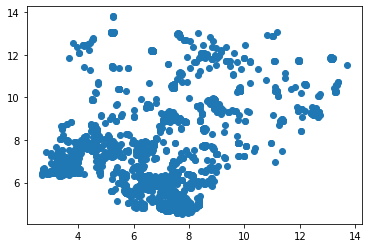

In [61]:
plt.scatter(nga_speed_df.long,nga_speed_df.lat)
plt.show()

In [62]:
nga_speed_df = (
    nga_speed_df[
        ["hex_code", "avg_d_kbps", "avg_u_kbps", "avg_lat_ms", "tests", "devices"]
    ]
    .groupby("hex_code")
    .agg(
        {
            "avg_d_kbps": "mean",
            "avg_u_kbps": "mean",
            "avg_lat_ms": "mean",
            "tests": "sum",
            "devices": "sum",
        }
    )
)


In [63]:
new_nga_df = nga_df.join(nga_cell_df.set_index("hex_code"), on=["hex_code"], how='left').join(
    nga_speed_df, on='hex_code', how='left'
)
# new_nga_df.iloc[:, 92:].fillna(0, inplace=True)


In [64]:
new_nga_df.n_conflicts.fillna(0, inplace=True)


In [65]:
new_nga_df.head()


,hex_code,year,round,cluster,hhid,indid,location,sex,wealth,wealthscore,age,hhweight,sumpoor_sev,dep_housing_sev,dep_water_sev,dep_sanitation_sev,dep_nutrition_sev,dep_health_sev,dep_education_sev,deprived_sev,region,region2,LATNUM,LONGNUM,Elevation,Slope,NDWI,NDVI,Road_density,cii,n_conflicts,n_education,n_health,OSM_hospital,OSM_school,health_gv_osm,school_gv_osm,Optical_Depth_047,Optical_Depth_055,F_0,F_1,F_10,F_15,F_20,F_25,F_30,F_35,F_40,F_45,F_5,F_50,F_55,F_60,F_65,F_70,F_75,F_80,M_0,M_1,M_10,M_15,M_20,M_25,M_30,M_35,M_40,M_45,M_5,M_50,M_55,M_60,M_65,M_70,M_75,M_80,population,PDSI,Evapotrans,built,cnfd,PrecipiS,PrecipiAcc,discrete_classification-proba_mean,discrete_classification_mean,PrecipiMean,avg_rad,cf_cvg,GDP_PPP_1990,GDP_PPP_2000,GDP_PPP_2015,Nigeria_EC2019,Nigeria_2019GDP,GSM,LTE,NR,UMTS,avg_signal,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
0,609534210041970687,2018.0,72.0,739.0,103.803738,5.523364,2.0,1.439252,1.140187,-124478.626168,7.831776,2.361982,1.682243,0.177570,0.000000,0.943925,0.500000,0.400000,0.636364,1.000000,3.0,20.0,13.082262,6.417623,1656.0,0.789573,-0.329164,1.449629,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.766197,429.430539,0.057965,0.219383,0.163050,0.124726,0.120279,0.108163,0.102888,0.066634,0.071879,0.034429,0.244100,0.047802,0.021363,0.029736,0.012698,0.016655,0.006594,0.006487,0.060364,0.228133,0.157959,0.126658,0.085037,0.082813,0.089990,0.069195,0.073443,0.039689,0.234607,0.050317,0.029000,0.031377,0.012422,0.017375,0.005782,0.005214,2.854207,672.428571,456.819109,2.047619,7.238095,0.091393,52.336184,46.090000,40.000000,0.068561,0.109068,7.723545,NaN,NaN,8.916271e+05,5571.969494,0.198119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,609534214102056959,2018.0,72.0,701.0,21.901099,5.219780,2.0,1.505495,1.461538,-108688.439560,7.076923,0.860969,1.615385,0.340659,0.000000,0.692308,0.538462,0.294118,0.694915,0.846154,3.0,10.0,13.282610,6.368814,1931.0,0.588017,-0.370748,1.165454,0.468752,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,481.278762,415.266877,0.069766,0.264044,0.193350,0.163181,0.151428,0.131460,0.118004,0.082325,0.084496,0.040219,0.295610,0.052223,0.024926,0.030402,0.013406,0.019066,0.006094,0.008298,0.074648,0.282117,0.200479,0.160844,0.110390,0.100373,0.099605,0.079704,0.076833,0.044777,0.288097,0.053609,0.033257,0.034409,0.015043,0.017363,0.007647,0.006628,3.434124,649.818182,411.574998,2.000000,0.409091,0.085988,46.677550,46.254545,39.090909,0.063376,0.115169,9.136364,1.461548e+06,1.308916e+06,2.496201e+06,3908.346591,0.138967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,609534229268660223,2018.0,72.0,738.0,26.513889,5.125000,2.0,1.444444,1.027778,-135450.652778,8.138889,0.998599,1.750000,0.000000,0.000000,0.902778,0.333333,0.466667,0.980769,0.986111,3.0,20.0,12.727340,6.168603,1768.0,2.429234,-0.466368,1.378060,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,466.735531,398.169291,0.023059,0.087273,0.064536,0.056903,0.048162,0.041406,0.034876,0.025445,0.022495,0.014278,0.085833,0.014973,0.007872,0.009626,0.004287,0.005597,0.002362,0.001921,0.024971,0.094372,0.075746,0.059610,0.041783,0.036472,0.034805,0.028318,0.024543,0.016724,0.098341,0.016037,0.008459,0.009888,0.003640,0.005264,0.002013,0.002064,1.133955,784.181818,539.503348,2.000000,0.000000,0.100014,61.793128,44.990909,24.545455,0.077517,0.106217,8.364899,NaN,NaN,NaN,3899.125710,0.138639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,609534232070455295,2018.0,72.0,733.0,16.504202,6.647059,2.0,1.504202,1.067227,-136376.226891,7.252101,0.455639,2.042017,0.151261,0.378151,0.907563,0.250000,0.393939,0.753425,0.949580,3.0,20.0,12.770098,5.826144,1412.0,0.764033,-0.056507,1.292410,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,478.371359,410.822028,0.018550,0.070208,0.050023,0.045589,0.039306,0.033540,0.031369,0.020068,0.021948,0.010839,0.073908,0.014138,0.006679,0.008894,0.003942,0.005422,0.001640,0.002367,0.019742,0.074612,0.057938,0.045215,0.029393,0.027305,0.028288,0.023206,0.022122,0.012780,0.078894,0.014973,0.009342,0.010008,0.004639,0.005000,0.0020

# Reproject CISI data and add in again 

In [66]:
pg.clip_tif_to_ctry(base_dir / "africa_cisi.tif", save_dir=base_dir)


In [67]:
pg.rxr_reproject_tiff_to_target(
    base_dir / "Nigeria_africa_cisi.tif",
    tiff_dir / "cpiPopData_500.tif",
    dest_path=base_dir / "nga_cisi.tif",
    verbose=True,
)


The crs of your data is: EPSG:4326
The nodatavalue of your data is: nan
The shape of your data is: (1, 2145, 2675)
The spatial resolution for your data is: (0.004491576420585397, -0.0044915764206098175)
The metadata for your data is: {'scale_factor': 1.0, 'add_offset': 0.0}
The crs of your data is: EPSG:4326
The nodatavalue of your data is: None
The shape of your data is: (37, 2145, 2675)
The spatial resolution for your data is: (0.004491576420585397, -0.0044915764206098175)
The metadata for your data is: {'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': ('population', 'M_0', 'M_1', 'M_5', 'M_10', 'M_15', 'M_20', 'M_25', 'M_30', 'M_35', 'M_40', 'M_45', 'M_50', 'M_55', 'M_60', 'M_65', 'M_70', 'M_75', 'M_80', 'F_0', 'F_1', 'F_5', 'F_10', 'F_15', 'F_20', 'F_25', 'F_30', 'F_35', 'F_40', 'F_45', 'F_50', 'F_55', 'F_60', 'F_65', 'F_70', 'F_75', 'F_80')}


In [68]:
alt_nga_df = pg.agg_tif_to_df(new_nga_df,base_dir / "nga_cisi.tif",rm_prefix='nga_',verbose=True) 

Working with cis: 1/1...
The crs of nga_cisi.tif is: EPSG:4326
The nodatavalue of nga_cisi.tif is: nan
The shape of nga_cisi.tif is: (1, 2145, 2675)
The spatial resolution for nga_cisi.tif is: (0.004491576420585397, -0.0044915764206098175)
The metadata for nga_cisi.tif is: {'scale_factor': 1.0, 'add_offset': 0.0}
Single band found only
1 bands found in nga_cis
Converted to dataframe!
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683906 entries, 0 to 3683905
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   latitude   float64
 1   longitude  float64
 2   nga_cis    float64
dtypes: float64(3)
memory usage: 84.3 MB
None
Adding hex info...
Large dataframe, using dask instead...
Using 88 partitions
Done!
Aggregating within cells...
Joining to survey data...
Done!


In [69]:
alt_nga_df.drop(columns=['cii'],inplace=True)

In [70]:
zero_fill_cols = [
    "GSM",
    "LTE",
    "NR",
    "UMTS",
    "tests",
    "devices",
]
alt_nga_df.fillna(value={col: 0 for col in zero_fill_cols}, inplace=True)
alt_nga_df.head()


,hex_code,year,round,cluster,hhid,indid,location,sex,wealth,wealthscore,age,hhweight,sumpoor_sev,dep_housing_sev,dep_water_sev,dep_sanitation_sev,dep_nutrition_sev,dep_health_sev,dep_education_sev,deprived_sev,region,region2,LATNUM,LONGNUM,Elevation,Slope,NDWI,NDVI,Road_density,n_conflicts,n_education,n_health,OSM_hospital,OSM_school,health_gv_osm,school_gv_osm,Optical_Depth_047,Optical_Depth_055,F_0,F_1,F_10,F_15,F_20,F_25,F_30,F_35,F_40,F_45,F_5,F_50,F_55,F_60,F_65,F_70,F_75,F_80,M_0,M_1,M_10,M_15,M_20,M_25,M_30,M_35,M_40,M_45,M_5,M_50,M_55,M_60,M_65,M_70,M_75,M_80,population,PDSI,Evapotrans,built,cnfd,PrecipiS,PrecipiAcc,discrete_classification-proba_mean,discrete_classification_mean,PrecipiMean,avg_rad,cf_cvg,GDP_PPP_1990,GDP_PPP_2000,GDP_PPP_2015,Nigeria_EC2019,Nigeria_2019GDP,GSM,LTE,NR,UMTS,avg_signal,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,nga_cis
0,609534210041970687,2018.0,72.0,739.0,103.803738,5.523364,2.0,1.439252,1.140187,-124478.626168,7.831776,2.361982,1.682243,0.177570,0.000000,0.943925,0.500000,0.400000,0.636364,1.000000,3.0,20.0,13.082262,6.417623,1656.0,0.789573,-0.329164,1.449629,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.766197,429.430539,0.057965,0.219383,0.163050,0.124726,0.120279,0.108163,0.102888,0.066634,0.071879,0.034429,0.244100,0.047802,0.021363,0.029736,0.012698,0.016655,0.006594,0.006487,0.060364,0.228133,0.157959,0.126658,0.085037,0.082813,0.089990,0.069195,0.073443,0.039689,0.234607,0.050317,0.029000,0.031377,0.012422,0.017375,0.005782,0.005214,2.854207,672.428571,456.819109,2.047619,7.238095,0.091393,52.336184,46.090000,40.000000,0.068561,0.109068,7.723545,NaN,NaN,8.916271e+05,5571.969494,0.198119,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.005211
1,609534214102056959,2018.0,72.0,701.0,21.901099,5.219780,2.0,1.505495,1.461538,-108688.439560,7.076923,0.860969,1.615385,0.340659,0.000000,0.692308,0.538462,0.294118,0.694915,0.846154,3.0,10.0,13.282610,6.368814,1931.0,0.588017,-0.370748,1.165454,0.468752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,481.278762,415.266877,0.069766,0.264044,0.193350,0.163181,0.151428,0.131460,0.118004,0.082325,0.084496,0.040219,0.295610,0.052223,0.024926,0.030402,0.013406,0.019066,0.006094,0.008298,0.074648,0.282117,0.200479,0.160844,0.110390,0.100373,0.099605,0.079704,0.076833,0.044777,0.288097,0.053609,0.033257,0.034409,0.015043,0.017363,0.007647,0.006628,3.434124,649.818182,411.574998,2.000000,0.409091,0.085988,46.677550,46.254545,39.090909,0.063376,0.115169,9.136364,1.461548e+06,1.308916e+06,2.496201e+06,3908.346591,0.138967,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.005214
2,609534229268660223,2018.0,72.0,738.0,26.513889,5.125000,2.0,1.444444,1.027778,-135450.652778,8.138889,0.998599,1.750000,0.000000,0.000000,0.902778,0.333333,0.466667,0.980769,0.986111,3.0,20.0,12.727340,6.168603,1768.0,2.429234,-0.466368,1.378060,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,466.735531,398.169291,0.023059,0.087273,0.064536,0.056903,0.048162,0.041406,0.034876,0.025445,0.022495,0.014278,0.085833,0.014973,0.007872,0.009626,0.004287,0.005597,0.002362,0.001921,0.024971,0.094372,0.075746,0.059610,0.041783,0.036472,0.034805,0.028318,0.024543,0.016724,0.098341,0.016037,0.008459,0.009888,0.003640,0.005264,0.002013,0.002064,1.133955,784.181818,539.503348,2.000000,0.000000,0.100014,61.793128,44.990909,24.545455,0.077517,0.106217,8.364899,NaN,NaN,NaN,3899.125710,0.138639,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.006386
3,609534232070455295,2018.0,72.0,733.0,16.504202,6.647059,2.0,1.504202,1.067227,-136376.226891,7.252101,0.455639,2.042017,0.151261,0.378151,0.907563,0.250000,0.393939,0.753425,0.949580,3.0,20.0,12.770098,5.826144,1412.0,0.764033,-0.056507,1.292410,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,478.371359,410.822028,0.018550,0.070208,0.050023,0.045589,0.039306,0.033540,0.031369,0.020068,0.021948,0.010839,0.073908,0.014138,0.006679,0.008894,0.003942,0.005422,0.001640,0.002367,0.019742,0.074612,0.057938,0.045215,0.029393,0.027305,0.028288,0.023206,0.022122,0.012780,0.078894,0.014973,0.009342,0.010008,0.004639,

In [71]:
alt_nga_df = pg.agg_tif_to_df(alt_nga_df,tiff_dir / "cpiHealthAccData_500.tif",verbose=True) 

Working with HealthAccData_500: 1/1...
The crs of cpiHealthAccData_500.tif is: EPSG:4326
The nodatavalue of cpiHealthAccData_500.tif is: None
The shape of cpiHealthAccData_500.tif is: (2, 2145, 2675)
The spatial resolution for cpiHealthAccData_500.tif is: (0.004491576420585397, -0.0044915764206098175)
The metadata for cpiHealthAccData_500.tif is: {'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': ('accessibility', 'accessibility_walking_only')}
Converted to dataframe!
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3714681 entries, 0 to 3714680
Data columns (total 4 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   latitude                    float64
 1   longitude                   float64
 2   accessibility               float32
 3   accessibility_walking_only  float32
dtypes: float32(2), float64(2)
memory usage: 85.0 MB
None
Adding hex info...
Large dataframe, using dask instead...
Using 89 partitions
Done!
Aggregat

In [72]:
autoh7 = pd.read_csv(base_dir / "autoencoder_highres7.csv",index_col=0) 
autol7 = pd.read_csv(base_dir / "autoencoder_lowres7.csv",index_col=0)  
autoh7.columns = [f'auto_h{i}' for i in range(len(autoh7.columns))]
autol7.columns = [f'auto_l{i}' for i in range(len(autol7.columns))]

In [73]:
alt_nga_df = alt_nga_df.join(autoh7,on='hex_code',how='left').join(autol7,on='hex_code',how='left')

In [74]:
alt_nga_df.head()

,hex_code,year,round,cluster,hhid,indid,location,sex,wealth,wealthscore,age,hhweight,sumpoor_sev,dep_housing_sev,dep_water_sev,dep_sanitation_sev,dep_nutrition_sev,dep_health_sev,dep_education_sev,deprived_sev,region,region2,LATNUM,LONGNUM,Elevation,Slope,NDWI,NDVI,Road_density,n_conflicts,n_education,n_health,OSM_hospital,OSM_school,health_gv_osm,school_gv_osm,Optical_Depth_047,Optical_Depth_055,F_0,F_1,F_10,F_15,F_20,F_25,F_30,F_35,F_40,F_45,F_5,F_50,F_55,F_60,F_65,F_70,F_75,F_80,M_0,M_1,M_10,M_15,M_20,M_25,M_30,M_35,M_40,M_45,M_5,M_50,M_55,M_60,M_65,M_70,M_75,M_80,population,PDSI,Evapotrans,built,cnfd,PrecipiS,PrecipiAcc,discrete_classification-proba_mean,discrete_classification_mean,PrecipiMean,avg_rad,cf_cvg,GDP_PPP_1990,GDP_PPP_2000,GDP_PPP_2015,Nigeria_EC2019,Nigeria_2019GDP,GSM,LTE,NR,UMTS,avg_signal,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,nga_cis,accessibility,accessibility_walking_only,auto_h0,auto_h1,auto_h2,auto_h3,auto_h4,auto_h5,auto_h6,auto_h7,auto_h8,auto_h9,auto_h10,auto_h11,auto_h12,auto_h13,auto_h14,auto_h15,auto_h16,auto_h17,auto_h18,auto_h19,auto_h20,auto_h21,auto_h22,auto_h23,auto_h24,auto_h25,auto_h26,auto_h27,auto_h28,auto_h29,auto_h30,auto_h31,auto_l0,auto_l1,auto_l2,auto_l3,auto_l4,auto_l5,auto_l6,auto_l7
0,609534210041970687,2018.0,72.0,739.0,103.803738,5.523364,2.0,1.439252,1.140187,-124478.626168,7.831776,2.361982,1.682243,0.177570,0.000000,0.943925,0.500000,0.400000,0.636364,1.000000,3.0,20.0,13.082262,6.417623,1656.0,0.789573,-0.329164,1.449629,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.766197,429.430539,0.057965,0.219383,0.163050,0.124726,0.120279,0.108163,0.102888,0.066634,0.071879,0.034429,0.244100,0.047802,0.021363,0.029736,0.012698,0.016655,0.006594,0.006487,0.060364,0.228133,0.157959,0.126658,0.085037,0.082813,0.089990,0.069195,0.073443,0.039689,0.234607,0.050317,0.029000,0.031377,0.012422,0.017375,0.005782,0.005214,2.854207,672.428571,456.819109,2.047619,7.238095,0.091393,52.336184,46.090000,40.000000,0.068561,0.109068,7.723545,NaN,NaN,8.916271e+05,5571.969494,0.198119,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.005211,5.470185,32.476190,0.0,4249.1140,0.0,0.0000,5510.4070,0.0,182.77043,0.0,0.0,3615.1675,1827.9453,0.0,3998.5413,1959.6118,0.0,0.0,0.00000,378.96347,4.550097,0.0000,104.108250,0.0000,2040.7487,0.0000,0.0,0.0,20.660196,0.000000,41.895150,90.266266,3050.6720,0.0,0.0,4614.9470,7139.0430,7835.1377,5172.3833,6306.8080,0.0,2018.8165
1,609534214102056959,2018.0,72.0,701.0,21.901099,5.219780,2.0,1.505495,1.461538,-108688.439560,7.076923,0.860969,1.615385,0.340659,0.000000,0.692308,0.538462,0.294118,0.694915,0.846154,3.0,10.0,13.282610,6.368814,1931.0,0.588017,-0.370748,1.165454,0.468752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,481.278762,415.266877,0.069766,0.264044,0.193350,0.163181,0.151428,0.131460,0.118004,0.082325,0.084496,0.040219,0.295610,0.052223,0.024926,0.030402,0.013406,0.019066,0.006094,0.008298,0.074648,0.282117,0.200479,0.160844,0.110390,0.100373,0.099605,0.079704,0.076833,0.044777,0.288097,0.053609,0.033257,0.034409,0.015043,0.017363,0.007647,0.006628,3.434124,649.818182,411.574998,2.000000,0.409091,0.085988,46.677550,46.254545,39.090909,0.063376,0.115169,9.136364,1.461548e+06,1.308916e+06,2.496201e+06,3908.346591,0.138967,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.005214,6.090442,24.318182,0.0,4022.7360,0.0,0.0000,5135.0527,0.0,79.48161,0.0,0.0,3392.8180,1816.4929,0.0,3882.5269,1855.7861,0.0,0.0,0.00000,364.80185,4.297480,0.0000,93.524254,0.0000,1934.6962,0.0000,0.0,0.0,19.599932,0.000000,38.183460,80.421110,2904.5127,0.0,0.0,4504.6235,6940.7246,7597.2954,5021.9050,6112.4290,0.0,1974.2653
2,609534229268660223,2018.0,72.0,738.0,26.513889,5.125000,2.0,1.444444,1.027778,-135450.652778,8.138889,0.998599,1.750000,0.000000,0.000000,0.902778,0.333333,0.466667,0.980769,0.986111,3.0,20.0,12.727340,6.168603,1768.0,2.429234,-0.466368,1.378060,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,466.735531,398.169291,0.023059,0.087273,0.064536,0.056903,0.048162,0.041406,0.034876,0.025445,0.022495,0.014278,0.

In [75]:
commute_df = pd.read_csv(base_dir / "nga_clean_justnewcomm_zns.csv")[
    [
        "hex_code",
        "name_commuting_zone",
        "population_commuting",
        "road_len_commuting",
        "area_commuting",
    ]
]
if commute_df.columns[1] in alt_nga_df: 
    alt_nga_df.drop(columns=commute_df.columns.tolist()[1:],inplace=True)
alt_nga_df = alt_nga_df.join(commute_df.set_index('hex_code'),on='hex_code',how='left')

In [76]:
alt_nga_df.to_csv(base_dir / "clean_nga_w_autov1.csv",index=False)

# Try mapping data to neighbours

In [ ]:
full_nga_data = pd.read_csv(
    "/Users/johnf/Downloads/raw_low_res_dssg/dhs/clean_nga_dhs.csv"
)


In [ ]:
plt.scatter(nga_df.LONGNUM, nga_df.LATNUM, c=nga_df.location)
plt.colorbar()
plt.show()


In [ ]:
full_nga_data.location.astype("category").describe()
# 1 is urban, 2 is rural


In [ ]:
full_nga_data["hex_incl_nbrs"] = full_nga_data[["location", "hex_code"]].apply(
    lambda row: h3.k_ring(row["hex_code"], 1)
    if row["location"] == 1
    else h3.k_ring(row["hex_code"], 2),
    axis=1,
)  # h3.hex_ring for hollow


In [ ]:
sev_cols = [col for col in full_nga_data.columns if "_sev" in col]


In [ ]:
other_cols = [
    col
    for col in full_nga_data.columns
    if (
        "int" in str(full_nga_data[col].dtype)
        or "float" in str(full_nga_data[col].dtype)
    )
]
agg_dict = {col: "mean" for col in other_cols}
agg_dict.update({idx: ["mean", "count"] for idx in sev_cols})
# agg_dict.update({"hhid": "count"})
new_df = (
    full_nga_data.explode("hex_incl_nbrs").groupby(by=["hex_incl_nbrs"]).agg(agg_dict)
)
new_df.columns = ["_".join(col) for col in new_df.columns.values]


In [ ]:
sev_cols


In [ ]:
new_df.rename(
    columns={
        f"{sev}_mean": f"{sev.lstrip('dep_').rstrip('_sev')}_prev"
        for sev in sev_cols
        if sev != "deprived_sev"
    },
    inplace=True,
)
new_df.rename(
    columns={
        f"{sev}_count": f"{sev.lstrip('dep_').rstrip('_sev')}_count"
        for sev in sev_cols
        if sev != "deprived_sev"
    },
    inplace=True,
)
new_df.rename(
    columns={"ucation_count": "education_count", "ucation_prev": "education_prev"},
    inplace=True,
)


In [ ]:
new_df.head().columns


In [ ]:
new_df.to_csv(base_dir / "nga_clean_expanded.csv")


In [ ]:
new_df = pd.read_csv(base_dir / "nga_clean_expanded.csv")
new_df[new_df["nutrition_count"] >= 10]


In [ ]:
sev_cols = [col for col in full_nga_data.columns if "sev" in col]


In [ ]:
full_nga_data["ndeps_missing"] = full_nga_data[sev_cols].isna().sum(axis=1)


In [ ]:
((6 - full_nga_data["ndeps_missing"] - full_nga_data["sumpoor_sev"]) < 0).sum()


In [ ]:
full_nga_data.ndeps_missing.describe()


In [ ]:
full_nga_data[sev_cols].info()


In [ ]:
full_nga_data.age.describe()


In [ ]:
# one vs all training


In [ ]:
import h3.api.numpy_int as h3


In [ ]:
res_level = 3
for col in sev_cols:
    full_nga_data[f"hex_code{res_level}"] = full_nga_data[["LATNUM", "LONGNUM"]].apply(
        lambda row: h3.geo_to_h3(*row.values, res_level), axis=1
    )
    count_df = full_nga_data.groupby(f"hex_code{res_level}")[col].count()
    _, bins = pd.qcut(count_df, [0, 0.05, 1.0], retbins=True)
    # print(f"5% cutoff for {col} is at {bins[1]}")
    if bins[1] < 30:
        quants = pd.cut(count_df, [0, 30, np.inf])
        cut_prop = quants.value_counts().sort_index().values[0] / len(count_df)
        print(f"Warning: cutoff at 30 for {col} removes {cut_prop*100:.2f}% of data")
        print(f"5% cutoff is at {bins[1]}")
        for thresh in [5, 10, 15, 20]:
            quants = pd.cut(count_df, [0, thresh, np.inf])
            cut_prop = quants.value_counts().sort_index().values[0] / len(count_df)
            print(f"Cutoff at {thresh} for {col} removes {cut_prop*100:.2f}% of data")
# count_df.hist(bins=100)
# plt.show()


In [ ]:
thr_df = nga_df.loc[count_df.values >= 30].copy()


In [ ]:
thr_df.to_csv(clean_base.parent / "nga_clean_v2_thr30.csv", index=False)


# First add higher res TIFF data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
nga_df = pg.agg_tif_to_df(
    nga_df,
    tiff_dir,
    rm_prefix="cpi",
    agg_fn=np.mean,
    max_records=int(1e5),
    replace_old=True,
    verbose=False,
)


In [ ]:
merge_cols = [col for col in nga_df.columns if "Data_500" in col]
old_cols = [col for col in merge_cols if col.rstrip("Data_500") in nga_df.columns]
nga_df.drop(columns=old_cols, inplace=True)
nga_df.rename(columns={col: col.rstrip("Data_500") for col in merge_cols}, inplace=True)


In [ ]:
nga_df.to_csv(clean_base, index=False)


In [ ]:
pd.set_option("display.max_columns", None)
nga_df.head()


# Now add econ TIFF data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
import glob

econ_tiffs = glob.glob(str(econ_dir / "*.tif"))


In [ ]:
econ_tiffs


In [ ]:
import rioxarray as rxr

# Convert econ tiffs to right resolution + CRS, rewrite to high_res dir
for i, econ_tiff in enumerate(econ_tiffs):
    with rxr.open_rasterio(econ_tiff) as data:
        name = Path(econ_tiff).name
        if "GDP_PPP" in name:
            data.attrs["long_name"] = ["GDP_PPP_1990", "GDP_PPP_2000", "GDP_PPP_2015"]
        elif "2019GDP" in name:
            data.attrs["long_name"] = ["GDP_2019"]
        elif "EC" in name:
            data.attrs["long_name"] = ["EC_2019"]
        data.rio.to_raster(econ_tiff)
    pg.rxr_reproject_tiff_to_target(
        econ_tiff,
        glob.glob(str(tiff_dir / "*.tif"))[0],
        tiff_dir / Path(econ_tiff).name,
        verbose=True,
    )


In [ ]:
high_res_econ_tifs = [
    name
    for name in glob.glob(str(tiff_dir / "*.tif"))
    if "GDP" in Path(name).name or "EC" in Path(name).name
]


In [ ]:
high_res_econ_tifs


In [ ]:
nga_df = pg.agg_tif_to_df(
    nga_df,
    high_res_econ_tifs,
    rm_prefix="Nigeria_",
    agg_fn=np.mean,
    max_records=int(1e5),
    replace_old=True,
    verbose=False,
)


In [ ]:
nga_df.head()


In [ ]:
nga_df.to_csv(clean_base, index=False)


# Now add commuter zone data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
import geopandas as gpd

commzns_df = pd.read_csv(comm_zns)


In [ ]:
from shapely import wkt

commzns_df["geometry"] = commzns_df["geometry"].apply(wkt.loads)


In [ ]:
commzns_df = gpd.GeoDataFrame(commzns_df, crs="epsg:4326")


In [ ]:
commzns_df[commzns_df["country"] == "Nigeria"].head(2)


In [ ]:
# TODO: decide if will add


In [ ]:
nga_df.to_csv(clean_base, index=False)


# Now add FB connectivity data

In [77]:
nga_df = pd.read_csv(base_dir / "clean_nga_w_autov1.csv")


In [78]:
conn_df = pd.read_csv(fb_conn)
conn_gdf = gpd.GeoDataFrame(
    conn_df, geometry=gpd.points_from_xy(conn_df.long, conn_df.lat)
)


In [79]:
conn_df['hex_code']=conn_df[['lat','long']].swifter.apply(lambda row: h3.geo_to_h3(row[0],row[1],resolution=7),axis=1)

Pandas Apply:   0%|          | 0/1344 [00:00<?, ?it/s]

In [80]:
nga_df = nga_df.join(conn_df.set_index('hex_code')['estimate_dau'],on='hex_code')

In [81]:
nga_df.to_csv(base_dir / "clean_nga_w_autov1.csv", index=False)

In [87]:
print(*sorted([(name,val) for name,val in zip(nga_df.isna().sum(axis=0).index,nga_df.isna().sum(axis=0).values)],key=lambda x: x[1]),sep='\n')

('hex_code', 0)
('year', 0)
('round', 0)
('cluster', 0)
('hhid', 0)
('indid', 0)
('location', 0)
('sex', 0)
('wealth', 0)
('wealthscore', 0)
('age', 0)
('hhweight', 0)
('sumpoor_sev', 0)
('dep_housing_sev', 0)
('dep_water_sev', 0)
('dep_sanitation_sev', 0)
('dep_health_sev', 0)
('dep_education_sev', 0)
('deprived_sev', 0)
('region', 0)
('region2', 0)
('LATNUM', 0)
('LONGNUM', 0)
('n_conflicts', 0)
('n_education', 0)
('n_health', 0)
('OSM_hospital', 0)
('OSM_school', 0)
('health_gv_osm', 0)
('school_gv_osm', 0)
('GSM', 0)
('LTE', 0)
('NR', 0)
('UMTS', 0)
('tests', 0)
('devices', 0)
('auto_h0', 0)
('auto_h1', 0)
('auto_h2', 0)
('auto_h3', 0)
('auto_h4', 0)
('auto_h5', 0)
('auto_h6', 0)
('auto_h7', 0)
('auto_h8', 0)
('auto_h9', 0)
('auto_h10', 0)
('auto_h11', 0)
('auto_h12', 0)
('auto_h13', 0)
('auto_h14', 0)
('auto_h15', 0)
('auto_h16', 0)
('auto_h17', 0)
('auto_h18', 0)
('auto_h19', 0)
('auto_h20', 0)
('auto_h21', 0)
('auto_h22', 0)
('auto_h23', 0)
('auto_h24', 0)
('auto_h25', 0)
('auto

In [ ]:
# only for inside train set - worth including or not extensible?
conn_gdf.plot()


# Finally add RWI data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
from pyquadkey2 import quadkey as qk
from shapely.geometry import Polygon

# qk.QuadKey()
top_left = qk.TileAnchor.ANCHOR_NW
top_right = qk.TileAnchor.ANCHOR_NE
bottom_right = qk.TileAnchor.ANCHOR_SE
bottom_left = qk.TileAnchor.ANCHOR_SW
getattr(qk.TileAnchor, bottom_right)


In [ ]:
test_idx = "010302121"
square = [
    qk.from_str(test_idx).to_geo(anchor=point)
    for point in [top_left, top_right, bottom_right, bottom_left]
]
square = Polygon(square)


In [ ]:
import h3.api.numpy_int as h3

ex_idx = h3.geo_to_h3(*square.boundary.coords[0], resolution=6)
hex = Polygon(h3.h3_to_geo_boundary(ex_idx))


In [ ]:
# create intersection and calculate percentage intersection based on areas
intersection = hex.intersection(square)
percent_area = intersection.area / square.area * 100


In [ ]:
percent_area


In [ ]:
nga_df.to_csv(clean_base, index=False)
